In [17]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

In [18]:
# 전처리 모듈 preprocess_ 호출하여 전처리하기
import preprocess_
pre_ = preprocess_.pre()
data = pre_.preprocess__(path="./datasets_arima/KS200_from2019.csv", slice=['날짜', '종가'], column_=['Date', 'KS200'])
data.set_index('Date',inplace=True)

d:\ubion\Project_mini_re\arima\preprocess_.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Date'] = df['Date'].str.replace('[^0-9]', '')


Text(0.5, 1.0, 'KS200 Trend')

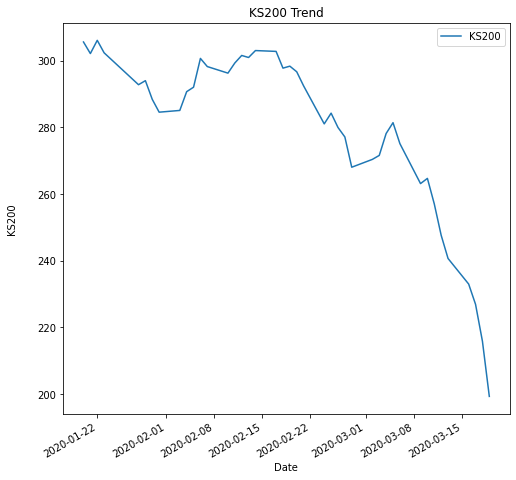

In [19]:
# xticks에 날짜를 표시하기 위해 Date열을 데이터프레임에 인덱스로 넣어주고 기존의 Date열 삭제
data_ = data.loc['2020-01-19':'2020-03-19']
data_.plot(figsize=(8,8))

# 유석님이 말씀하신 2020-01-19 ~ 2020-03-19 사이의 코스피200지수 
plt.ylabel("KS200", labelpad=20.0)
plt.title("KS200 Trend")

In [20]:
# 1월 19일은 일요일 존재 X
# 1월19일 부터 2월 17일을 train 시킨 경우
train = data.loc['2020-01-19':'2020-02-17']
target = data.loc['2020-02-18':'2020-03-19']
target_ = data.loc['2020-02-18':'2020-12-31']
train = np.log1p(train)
target = np.log1p(target)
target_ = np.log1p(target_)

In [21]:
# 2019년 1월 1일은 존재 X
# 2019년 1월1일 부터 2월 17일을 train 시킨 경우
# 혹시 더 많은 데이터를 train 시킬 경우 예측 결과가 차이가 날까 라는 의문에서 훈련기간을 1월 1일부터로 설정한 모델을 만들기 위해 따로 만들었고 해당 모델의 데이터들은 데이터뒤에 _가 붙어있다.
train_ = data.loc['2019-01-01':'2020-02-17']
train_ = np.log1p(train_)

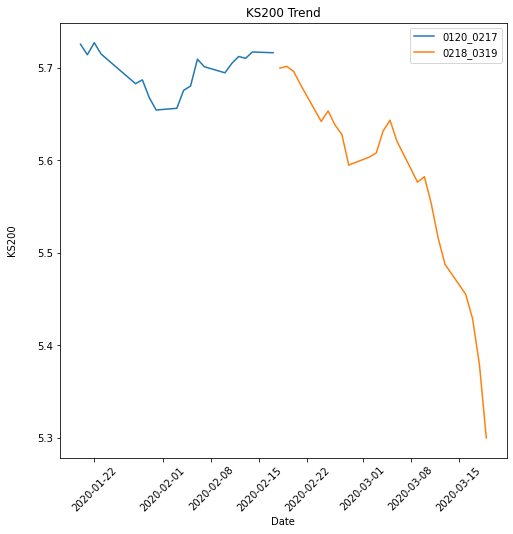

In [22]:
# 1월 19일은 일요일 존재 X
# 1월19일 부터 2월 17일을 train 시킨 경우
plt.figure(figsize=(8,8))
plt.plot(train)
plt.plot(target)

# rotation 45를 넣지 않으면 xtick의 날짜끼리 겹쳐서 제대로 보이지 않음
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('KS200', labelpad=20.0)
plt.title('KS200 Trend')
plt.legend(['0120_0217', '0218_0319'])
plt.show()

In [23]:
# 1월19일 부터 2월 17일까지의 데이터 차수 선정
kpss_diffs = ndiffs(train['KS200'], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train['KS200'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 3


In [24]:
# 2019년 1월1일 부터 2월 17일까지의 데이터 차수 선정
kpss_diffs_ = ndiffs(train_['KS200'], alpha=0.05, test='kpss', max_d=6)
adf_diffs_ = ndiffs(train_['KS200'], alpha=0.05, test='adf', max_d=6)
n_diffs_ = max(adf_diffs_, kpss_diffs_)

print(f"추정된 차수 d = {n_diffs_}")

추정된 차수 d = 1


In [25]:
# 1월19일 부터 2월 17일을 train 시킨 경우
model = pm.auto_arima(y = train['KS200']        # 데이터
                      , d = 3            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 5   
                      , start_q = 0 
                      , max_q = 5   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=-60.143, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=-65.052, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=-71.625, Time=0.04 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=-73.348, Time=0.14 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=-74.314, Time=0.14 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=-72.017, Time=0.09 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=-72.443, Time=0.15 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=-68.396, Time=0.20 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=-72.808, Time=0.09 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=-71.228, Time=0.12 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.317 seconds


In [26]:
# 2019년 1월1일 부터 2월 17일을 train 시킨 경우
model_ = pm.auto_arima(y = train_['KS200']        # 데이터
                      , d = 1            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 5   
                      , start_q = 0 
                      , max_q = 5   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1815.648, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1814.150, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1814.066, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1816.515, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1808.339, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.296 seconds


In [27]:
# 1월19일 부터 2월 17일을 train , 2020-12-31까지 예측
model__ = pm.auto_arima(y = train['KS200']        # 데이터
                      , d = 3            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 5   
                      , start_q = 0 
                      , max_q = 5   
                      , m = 1       
                      , seasonal = False # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=-60.143, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=-65.052, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=-71.625, Time=0.03 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=-73.348, Time=0.12 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=-74.314, Time=0.12 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=-72.017, Time=0.07 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=-72.443, Time=0.16 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=-68.396, Time=0.20 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=-72.808, Time=0.08 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=-71.228, Time=0.11 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.237 seconds


In [28]:
# 1월19일 부터 2월 17일을 train 시킨 경우
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   19
Model:               SARIMAX(2, 3, 1)   Log Likelihood                  41.157
Date:                Sat, 30 Apr 2022   AIC                            -74.314
Time:                        12:22:29   BIC                            -71.224
Sample:                             0   HQIC                           -74.156
                                 - 19                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6631      0.314     -2.114      0.034      -1.278      -0.048
ar.L2         -0.4228      0.295     -1.435      0.151      -1.000       0.154
ma.L1         -0.9228      0.643     -1.435      0.1

In [29]:
# 2019년 1월1일 부터 2월 17일을 train 시킨 경우
print(model_.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  277
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 909.258
Date:                Sat, 30 Apr 2022   AIC                          -1816.515
Time:                        12:22:29   BIC                          -1812.895
Sample:                             0   HQIC                         -1815.062
                                - 277                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.046e-05   5.66e-06     14.208      0.000    6.94e-05    9.16e-05
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                18.04
Prob(Q):                              0.48   Pr

### Ljung-Box(=Prob(Q)) :  일정 기간 동안 일련의 관측치가 랜덤이고 독립적인지 여부를 검사하는데 사용된다
    - 자기 상관 관계에서 시점간의 상관 관계를 의미하며, 자기 상관관계로 인하여 시계열 모형의 정확도를 떨어뜨리는 원인이 되기도 한다.
    - 귀무가설 : 자기상관성이 없다. 상관계수=0 / 대립가설 : 자기상관성이 있다. 상관계수≠0
    - Prob(Q)가 유의수준(0.05)보다 작으면 귀무가설을 기각하여 자기상관성이 존재한다는 의미이다.

### Jarque-Bera(=Prob(JB)) : 왜도와 첨도가 정규분포로 보기에 적합한지에 대한 적합도 검정에 사용한다
    - 귀무가설 : 데이터는 정규분포를 따른다. / 대립가설 : 데이터는 정규분포를 따르지 않는다.
    - Prob(JB)가 유의수준(0.05)보다 작으면 귀무가설을 기각하여 데이터는 정규분포를 따르지 않는다는 의미이다.

### Heteroskedasticity(=Prob(H)) : 각 시간대 별 잔차의 분산이 일정한지 보는 테스트
    - 귀무가설 : 잔차의 분산이 일정하다 / 대립가설 잔차의 분산이 일정하지 않다.
    - Prob(H)가 유의수준(0.05)보다 작으면 귀무가설을 기각하여 잔차의 분산이 일정하지 않다는 의미이다.

### Skew (왜도) : 분포가 정규분포에 비해 얼마나 비대칭인지 나타내는 척도

### Kurtosis (첨도) = 샘플의 점수가 평균을 중심으로 가까링 몰려 있을수록 분포의 정점은 더욱 뾰족한 모양. 즉 첨도가 커진다.


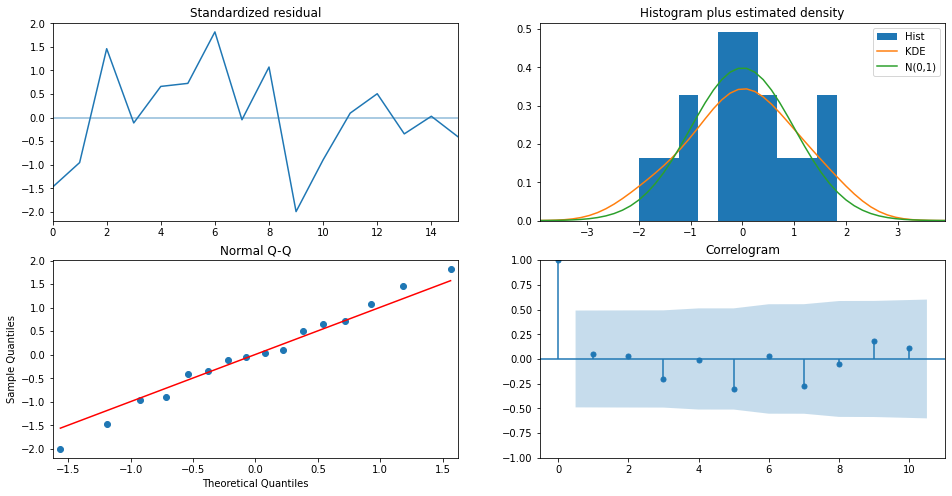

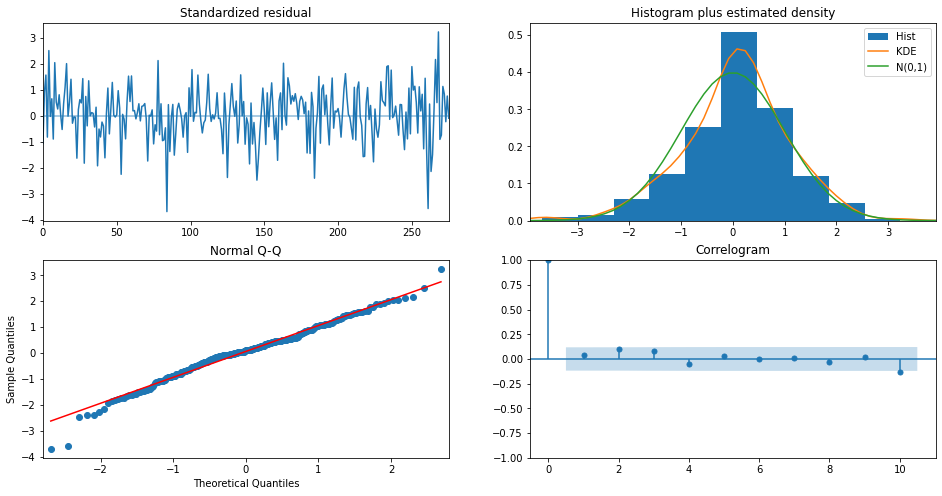

In [30]:
# 1월19일 부터 2월 17일을 train 시킨 경우
model.plot_diagnostics(figsize=(16, 8))
# 2019년 1월1일 부터 2월 17일을 train 시킨 경우
model_.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Standardized residual : 잔차를 시계열로 그린 것
#### Correlogram : 잔차에 대한 ACF와 허용범위를 나타낸 것
    - ACF란? 자기상관함수 (AutoCorrelation Function) 으로써 시차에 따른 일련의 자기상관을 의미하며 시차가 커질 수록 0에 가까워진다. 정상 시계열은 빠르게 0으로 수렴하며, 비정상 시계열은 천천히 감소하고 종종 양의 큰 값을 가진다
#### Histogram plus estimated density : 잔차의 히스토그램을 그려 정규분포 N(0,1)과 밀도를 추정한 그래프를 같이 겹쳐서 보여주는 것. 
#### Normal Q-Q : 수집데이터를 표준정규분포의 분위수와 비교하여 그리는 그래프로 데이터의 정규성 가정에 대한 검토를 가능하게 한다. 모집단이 정규성을 따른다면 직선의 형태로 그려지게 된다.

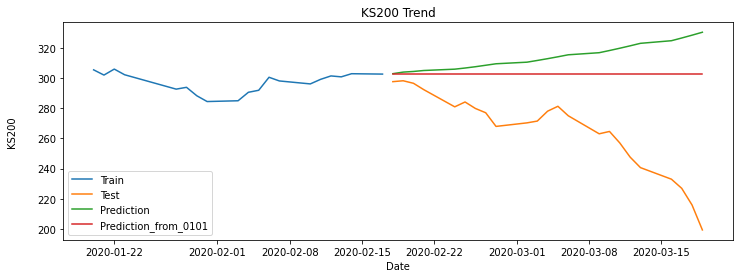

In [32]:
# 테스트 데이터 개수만큼 예측 (1월19일 부터 2월 17일을 train 시킨 경우)
y_predict = model.predict(n_periods=len(target['KS200'])) 
y_predict = pd.DataFrame(y_predict, index = target['KS200'].index, columns=['Prediction'])
# 2019년 1월1일 부터 2월 17일을 train 시킨 경우
y_predict_ = model_.predict(n_periods=len(target['KS200'])) 
y_predict_ = pd.DataFrame(y_predict_, index = target['KS200'].index, columns=['Prediction_'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(np.expm1(train['KS200']), label='Train')        # 훈련 데이터
plt.plot(np.expm1(target['KS200']), label='Test')          # 테스트 데이터
plt.plot(np.expm1(y_predict), label='Prediction')  # 예측 데이터 (1월19일부터훈련)
plt.plot(np.expm1(y_predict_), label='Prediction_from_0101') # 예측 데이터 (2019년 1월1일부터훈련)
plt.title("KS200 Trend")
plt.ylabel('KS200', labelpad=20.0)
plt.xlabel('Date')
plt.legend()
plt.show()

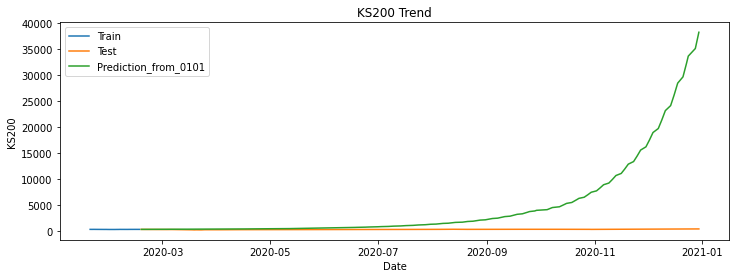

In [33]:
# 테스트 데이터 (2020-12-31)까지 예측 (1월19일 부터 2월 17일을 train 시킨 경우)
y_predict__ = model__.predict(n_periods=len(target_['KS200'])) 
y_predict__ = pd.DataFrame(y_predict__, index = target_['KS200'].index, columns=['Prediction'])


# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(np.expm1(train['KS200']), label='Train')        # 훈련 데이터
plt.plot(np.expm1(target_['KS200']), label='Test')          # 테스트 데이터
plt.plot(np.expm1(y_predict__), label='Prediction_from_0101') # 예측 데이터 (2019년 1월1일부터훈련)
plt.title("KS200 Trend")
plt.ylabel('KS200')
plt.xlabel('Date')
plt.legend()
plt.show()

In [34]:
# 관측치를 추가함으로써 모형을 refresh하고 이로 인해 AIC, 로그 가능도가 다시 계산되고 가장 마지막 관측치가 업데이트된다
# AIC(Akaike Information Criterion)란? 두 확률분포 사이의 차이를 표현한 것. 실제 데이터의 분포와 모형이 예측하는 분포 사이의 차이
# AIC가 작다는 것은 모형이 자료의 진짜 분포와 비슷하게 생겼다는 것
# 쉽게 설명한 곳 : https://student9725.tistory.com/28
# 좀 더 깊게 설명한 곳 : https://rk1993.tistory.com/entry/AIC-BIC-Mallows-Cp-%EC%89%BD%EA%B2%8C-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0
def forecast_one_step(model):
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [35]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in target['KS200']:
    fc, conf = forecast_one_step(model)
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [36]:
# 2019년 1월1일 부터 2월 17일을 train 시킨 경우
forecasts_ = []
y_pred_ = []
pred_upper_ = []
pred_lower_ = []

for new_ob_ in target['KS200']:
    fc_, conf_ = forecast_one_step(model_)
    y_pred_.append(fc_)
    pred_upper_.append(conf_[1])
    pred_lower_.append(conf_[0])

    ## 모형 업데이트 !!
    model_.update(new_ob_)

In [37]:
# 2019년 1월1일 부터 2월 17일을 train 시킨 경우
forecasts__ = []
y_pred__ = []
pred_upper__ = []
pred_lower__ = []

for new_ob__ in target_['KS200']:
    fc__, conf__ = forecast_one_step(model__)
    y_pred__.append(fc__)
    pred_upper__.append(conf__[1])
    pred_lower__.append(conf__[0])

    ## 모형 업데이트 !!
    model__.update(new_ob__)

In [38]:
pd.DataFrame({"test": np.expm1(target['KS200']), "pred": np.expm1(y_pred)})

,test,pred
Date,,
2020-02-18,297.74,303.038534
2020-02-19,298.33,296.495010
2020-02-20,296.65,297.160584
2020-02-21,292.42,293.828909
2020-02-24,281.02,290.520569
2020-02-25,284.24,274.540024
2020-02-26,279.94,280.837413
2020-02-27,277.09,273.991417
2020-02-28,268.02,276.429699


In [39]:
# 2019년 1월1일 부터 2월 17일을 train 시킨 경우
pd.DataFrame({"test": np.expm1(target['KS200']), "pred": np.expm1(y_pred_)})

,test,pred
Date,,
2020-02-18,297.74,302.76
2020-02-19,298.33,297.74
2020-02-20,296.65,298.33
2020-02-21,292.42,296.65
2020-02-24,281.02,292.42
2020-02-25,284.24,281.02
2020-02-26,279.94,284.24
2020-02-27,277.09,279.94
2020-02-28,268.02,277.09


In [40]:
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(2, 3, 1)   Log Likelihood                  94.044
Date:                Sat, 30 Apr 2022   AIC                           -180.088
Time:                        12:23:12   BIC                           -173.434
Sample:                             0   HQIC                          -177.701
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6073      0.211     -2.874      0.004      -1.021      -0.193
ar.L2         -0.3157      0.199     -1.589      0.112      -0.705       0.074
ma.L1         -0.9240      0.203     -4.552      0.0

In [41]:
# 2019년 1월1일 부터 2월 17일을 train 시킨 경우
print(model_.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 899.257
Date:                Sat, 30 Apr 2022   AIC                          -1796.514
Time:                        12:23:13   BIC                          -1792.814
Sample:                             0   HQIC                         -1795.033
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   5.28e-06     27.088      0.000       0.000       0.000
Ljung-Box (L1) (Q):                  20.15   Jarque-Bera (JB):               834.03
Prob(Q):                              0.00   Pr

In [42]:
## 1월1일부터 학습시킨 모델의 예측 결과와 1월19일부터 학습시킨 모델의 예측결과가 그래프상으로는 두드러지게 나타나지 않았다.
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    
    # 훈련 데이터(1월 1일부터)------------------------------------------------------------
    go.Scatter(x = train_['KS200'].index, y = np.expm1(train_['KS200']), name = "Train", mode = 'lines'
              ,line=dict(color = 'violet'))
    # 훈련 데이터(2019년 1월 19일부터)-----------------------------------------------------------
    , go.Scatter(x = train['KS200'].index, y = np.expm1(train['KS200']), name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터-----------------------------------------------------------------------
    , go.Scatter(x = target['KS200'].index, y = np.expm1(target['KS200']), name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값(2019년 1월 1일 부터 학습)-----------------------------------------------------------
    , go.Scatter(x = target['KS200'].index, y = np.expm1(y_pred_), name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'skyblue', dash = 'dot', width=3))     
        # 예측값(1월 19일 부터 학습)-----------------------------------------------------------
    , go.Scatter(x = target['KS200'].index, y = np.expm1(y_pred), name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))            
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = target['KS200'].index.tolist() + target['KS200'].index[::-1].tolist() 
                ,y = np.expm1(pred_upper).tolist() + np.expm1(pred_lower[::-1]).tolist() ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(2,3,1) / ARIMA(0,1.0)모형",
                    xaxis=go.layout.XAxis(
                        title=go.layout.xaxis.Title(
                            text="Date",
                            font=dict(
                                family="Courier New, monospace",
                                size=18,
                                )
                            )
                        ),
                    yaxis=go.layout.YAxis(
                        title=go.layout.yaxis.Title(
                            text="KS200",
                            font=dict(
                                family="Courier New, monospace",
                                size=18,
                                )
                            )
                        )
                    )
fig.show()



In [43]:
## 2020년 1월19일부터 학습시킨 모델로 2020년 12월 31일까지 예측
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    
    # 훈련 데이터(2020년 1월 19일부터 2월 17일까지)-----------------------------------------------------------
    go.Scatter(x = train['KS200'].index, y = np.expm1(train['KS200']), name = "Train 2020-01-19 ~ 2020-02-17", mode = 'lines'
              ,line=dict(color = 'royalblue'))
        # 예측값(1월 19일 부터 학습해서 2020년 12월 31일까지 예측)-----------------------------------------------------------
    , go.Scatter(x = target_['KS200'].index, y = np.expm1(y_pred__), name = "Prediction 2020-02-18 ~ 2020-12-13", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))     
        # 테스트 데이터-----------------------------------------------------------------------
    , go.Scatter(x = target_['KS200'].index, y = np.expm1(target_['KS200']), name = "Test", mode = 'lines'
              ,line = dict(color = 'rgba(0,0,30,0.5)'))       
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = target_['KS200'].index.tolist() + target_['KS200'].index[::-1].tolist() 
                ,y = np.expm1(pred_upper__).tolist() + np.expm1(pred_lower__[::-1]).tolist() ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(2,3,1)모형",
                    xaxis=go.layout.XAxis(
                                            title=go.layout.xaxis.Title(
                                                text="Date",
                                                font=dict(
                                                    family="Courier New, monospace",
                                                    size=18,
                                                    )
                                                )
                                            ),
                    yaxis=go.layout.YAxis(
                        title=go.layout.yaxis.Title(
                            text="KS200",
                            font=dict(
                                family="Courier New, monospace",
                                size=18,
                                )
                            )
                        )
                    )
fig.show()

In [44]:
# 학습을 1월 19일부터 시킨 모델과 2019년 1월 1일부터 시킨 모델의 차이 평균
np.mean([x-y for x,y in zip(np.expm1(y_pred), np.expm1(y_pred_))])

-3.4334161934989202

In [45]:
# 학습을 2020년 1월 19일부터 시킨경우 ARIMA(2,3,1)
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(np.expm1(target['KS200']), np.expm1(y_pred)):.3f}")
# MAPE: 0.792

MAPE: 1.890


In [46]:
# 학습을 2019년 1월 19일부터 시킨경우
# ARIMA(0,1,0) 확률보행(현재의 값을 예측할 수 있는 가장 좋은 값은 어제의 값)
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(np.expm1(target['KS200']), np.expm1(y_pred_)):.3f}")
# MAPE: 0.792


MAPE: 2.451


In [47]:
# 학습을 2020년 1월 19일부터 시킨경우 / 모델은 2020년 1월 19일부터와 같은 ARIMA(2,3,1) 사용
def MAPE(y_test, y_pred__):
	return np.mean(np.abs((y_test - y_pred__) / y_test)) * 100 
    
print(f"MAPE: {MAPE(np.expm1(target_['KS200']), np.expm1(y_pred__)):.3f}")
# MAPE: 0.792

MAPE: 1.474


### MAPE (mean absolute precentage error) MAE를 퍼센트로 변환한 것이다
    - MAE와 마찬가지로 MSE보다 특이치에 robust하다(상대적으로 영향을 덜 받는다--MSE는 제곱을 하기 때문)
    - MAE와 마찬가지로 절대값을 취하기 때문에 실제보다 높은지 낮은지 알 수 없다는 단점
